# Similarity Models Challenge (18.5)

### Instructions:

Find a data set and build a KNN Regression and an OLS regression. Compare the two. How similar are they? Do they miss in different ways?

Create a Jupyter notebook with your models. At the end in a markdown cell write a few paragraphs to describe the models' behaviors and why you favor one model or the other. Try to determine whether there is a situation where you would change your mind, or whether one is unambiguously better than the other. Lastly, try to note what it is about the data that causes the better model to outperform the weaker model. Submit a link to your notebook below.

### NOTE: This is following a template from an notebook we completed in class.

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

# Info from winequality.names

Citation Request:
  This dataset is public available for research. The details are described in [Cortez et al., 2009]. 
  Please include this citation if you plan to use this database:

  P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. 
  Modeling wine preferences by data mining from physicochemical properties.
  In Decision Support Systems, Elsevier, 47(4):547-553. ISSN: 0167-9236.

  Available at: [@Elsevier] http://dx.doi.org/10.1016/j.dss.2009.05.016
                [Pre-press (pdf)] http://www3.dsi.uminho.pt/pcortez/winequality09.pdf
                [bib] http://www3.dsi.uminho.pt/pcortez/dss09.bib

1. Title: Wine Quality 

2. Sources
   Created by: Paulo Cortez (Univ. Minho), Antonio Cerdeira, Fernando Almeida, Telmo Matos and Jose Reis (CVRVV) @ 2009
   
3. Past Usage:

  P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. 
  Modeling wine preferences by data mining from physicochemical properties.
  In Decision Support Systems, Elsevier, 47(4):547-553. ISSN: 0167-9236.

  In the above reference, two datasets were created, using red and white wine samples.
  The inputs include objective tests (e.g. PH values) and the output is based on sensory data
  (median of at least 3 evaluations made by wine experts). Each expert graded the wine quality 
  between 0 (very bad) and 10 (very excellent). Several data mining methods were applied to model
  these datasets under a regression approach. The support vector machine model achieved the
  best results. Several metrics were computed: MAD, confusion matrix for a fixed error tolerance (T),
  etc. Also, we plot the relative importances of the input variables (as measured by a sensitivity
  analysis procedure).
 
4. Relevant Information:

   The two datasets are related to red and white variants of the Portuguese "Vinho Verde" wine.
   For more details, consult: http://www.vinhoverde.pt/en/ or the reference [Cortez et al., 2009].
   Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables 
   are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.).

   These datasets can be viewed as classification or regression tasks.
   The classes are ordered and not balanced (e.g. there are munch more normal wines than
   excellent or poor ones). Outlier detection algorithms could be used to detect the few excellent
   or poor wines. Also, we are not sure if all input variables are relevant. So
   it could be interesting to test feature selection methods. 

5. Number of Instances: red wine - 1599; white wine - 4898. 

6. Number of Attributes: 11 + output attribute
  
   Note: several of the attributes may be correlated, thus it makes sense to apply some sort of
   feature selection.

7. Attribute information:

   For more information, read [Cortez et al., 2009].

   Input variables (based on physicochemical tests):
   1 - fixed acidity
   2 - volatile acidity
   3 - citric acid
   4 - residual sugar
   5 - chlorides
   6 - free sulfur dioxide
   7 - total sulfur dioxide
   8 - density
   9 - pH
   10 - sulphates
   11 - alcohol
   Output variable (based on sensory data): 
   12 - quality (score between 0 and 10)

8. Missing Attribute Values: None

# Data Import

In [66]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import seaborn as sns
import matplotlib.pyplot as plt

import warnings

%matplotlib inline

data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"

wines = pd.read_csv(data_url, sep=";")

<IPython.core.display.Javascript object>

In [35]:
def print_vif(x):
    """Utility for checking multicollinearity assumption
    
    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, int(i))
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs, index=x.columns))
    print("-------------------------------\n")

<IPython.core.display.Javascript object>

# General EDA

Do some *really* general eda.  i.e just stuff like shape/head/info/describe

In [4]:
wines.shape

(4898, 12)

<IPython.core.display.Javascript object>

In [5]:
wines.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


<IPython.core.display.Javascript object>

In [6]:
wines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
fixed acidity           4898 non-null float64
volatile acidity        4898 non-null float64
citric acid             4898 non-null float64
residual sugar          4898 non-null float64
chlorides               4898 non-null float64
free sulfur dioxide     4898 non-null float64
total sulfur dioxide    4898 non-null float64
density                 4898 non-null float64
pH                      4898 non-null float64
sulphates               4898 non-null float64
alcohol                 4898 non-null float64
quality                 4898 non-null int64
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


<IPython.core.display.Javascript object>

In [7]:
wines.isna().mean()

fixed acidity           0.0
volatile acidity        0.0
citric acid             0.0
residual sugar          0.0
chlorides               0.0
free sulfur dioxide     0.0
total sulfur dioxide    0.0
density                 0.0
pH                      0.0
sulphates               0.0
alcohol                 0.0
quality                 0.0
dtype: float64

<IPython.core.display.Javascript object>

In [8]:
wines.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


<IPython.core.display.Javascript object>

In [9]:
wines["quality"].value_counts()

6    2198
5    1457
7     880
8     175
4     163
3      20
9       5
Name: quality, dtype: int64

<IPython.core.display.Javascript object>

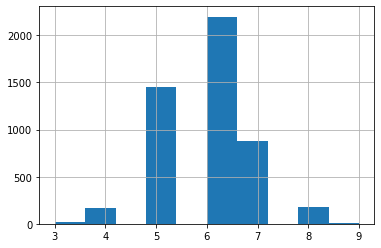

<IPython.core.display.Javascript object>

In [10]:
wines["quality"].hist()
plt.show()

All values look reasonable so far.  Nothing missing, all numerical.  But wow, that is a class imbalance problem if I ever saw one.  The description of the data did warn us.  Strategy: Drop the 3's and 9's and undersample the 5's, 6's and 7's to bring them to about 170 sample size.

In [14]:
# dropping 3's and 9's

wines = wines[wines["quality"] != 3]
wines = wines[wines["quality"] != 9]
wines["quality"].value_counts()

6    2198
5    1457
7     880
8     175
4     163
Name: quality, dtype: int64

<IPython.core.display.Javascript object>

In [22]:
fours = wines[wines["quality"] == 4]
eights = wines[wines["quality"] == 8]

new_fives = wines[wines["quality"] == 5].sample(n=175, random_state=42)
new_sixs = wines[wines["quality"] == 6].sample(n=175, random_state=3)
new_sevens = wines[wines["quality"] == 7].sample(n=175, random_state=1)

new_wines = pd.concat([fours, eights, new_fives, new_sixs, new_sevens])
new_wines.shape

(863, 12)

<IPython.core.display.Javascript object>

In [23]:
new_wines.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
46,6.2,0.450,0.26,4.4,0.063,63.0,206.0,0.9940,3.27,0.52,9.8,4
98,9.8,0.360,0.46,10.5,0.038,4.0,83.0,0.9956,2.89,0.30,10.1,4
115,5.5,0.485,0.00,1.5,0.065,8.0,103.0,0.9940,3.63,0.40,9.7,4
147,6.4,0.595,0.14,5.2,0.058,15.0,97.0,0.9951,3.38,0.36,9.0,4
172,7.6,0.480,0.37,0.8,0.037,4.0,100.0,0.9902,3.03,0.39,11.4,4


<IPython.core.display.Javascript object>

In [25]:
new_wines["quality"].value_counts()

8    175
7    175
6    175
5    175
4    163
Name: quality, dtype: int64

<IPython.core.display.Javascript object>

# Data Cleaning and Feature Engineering

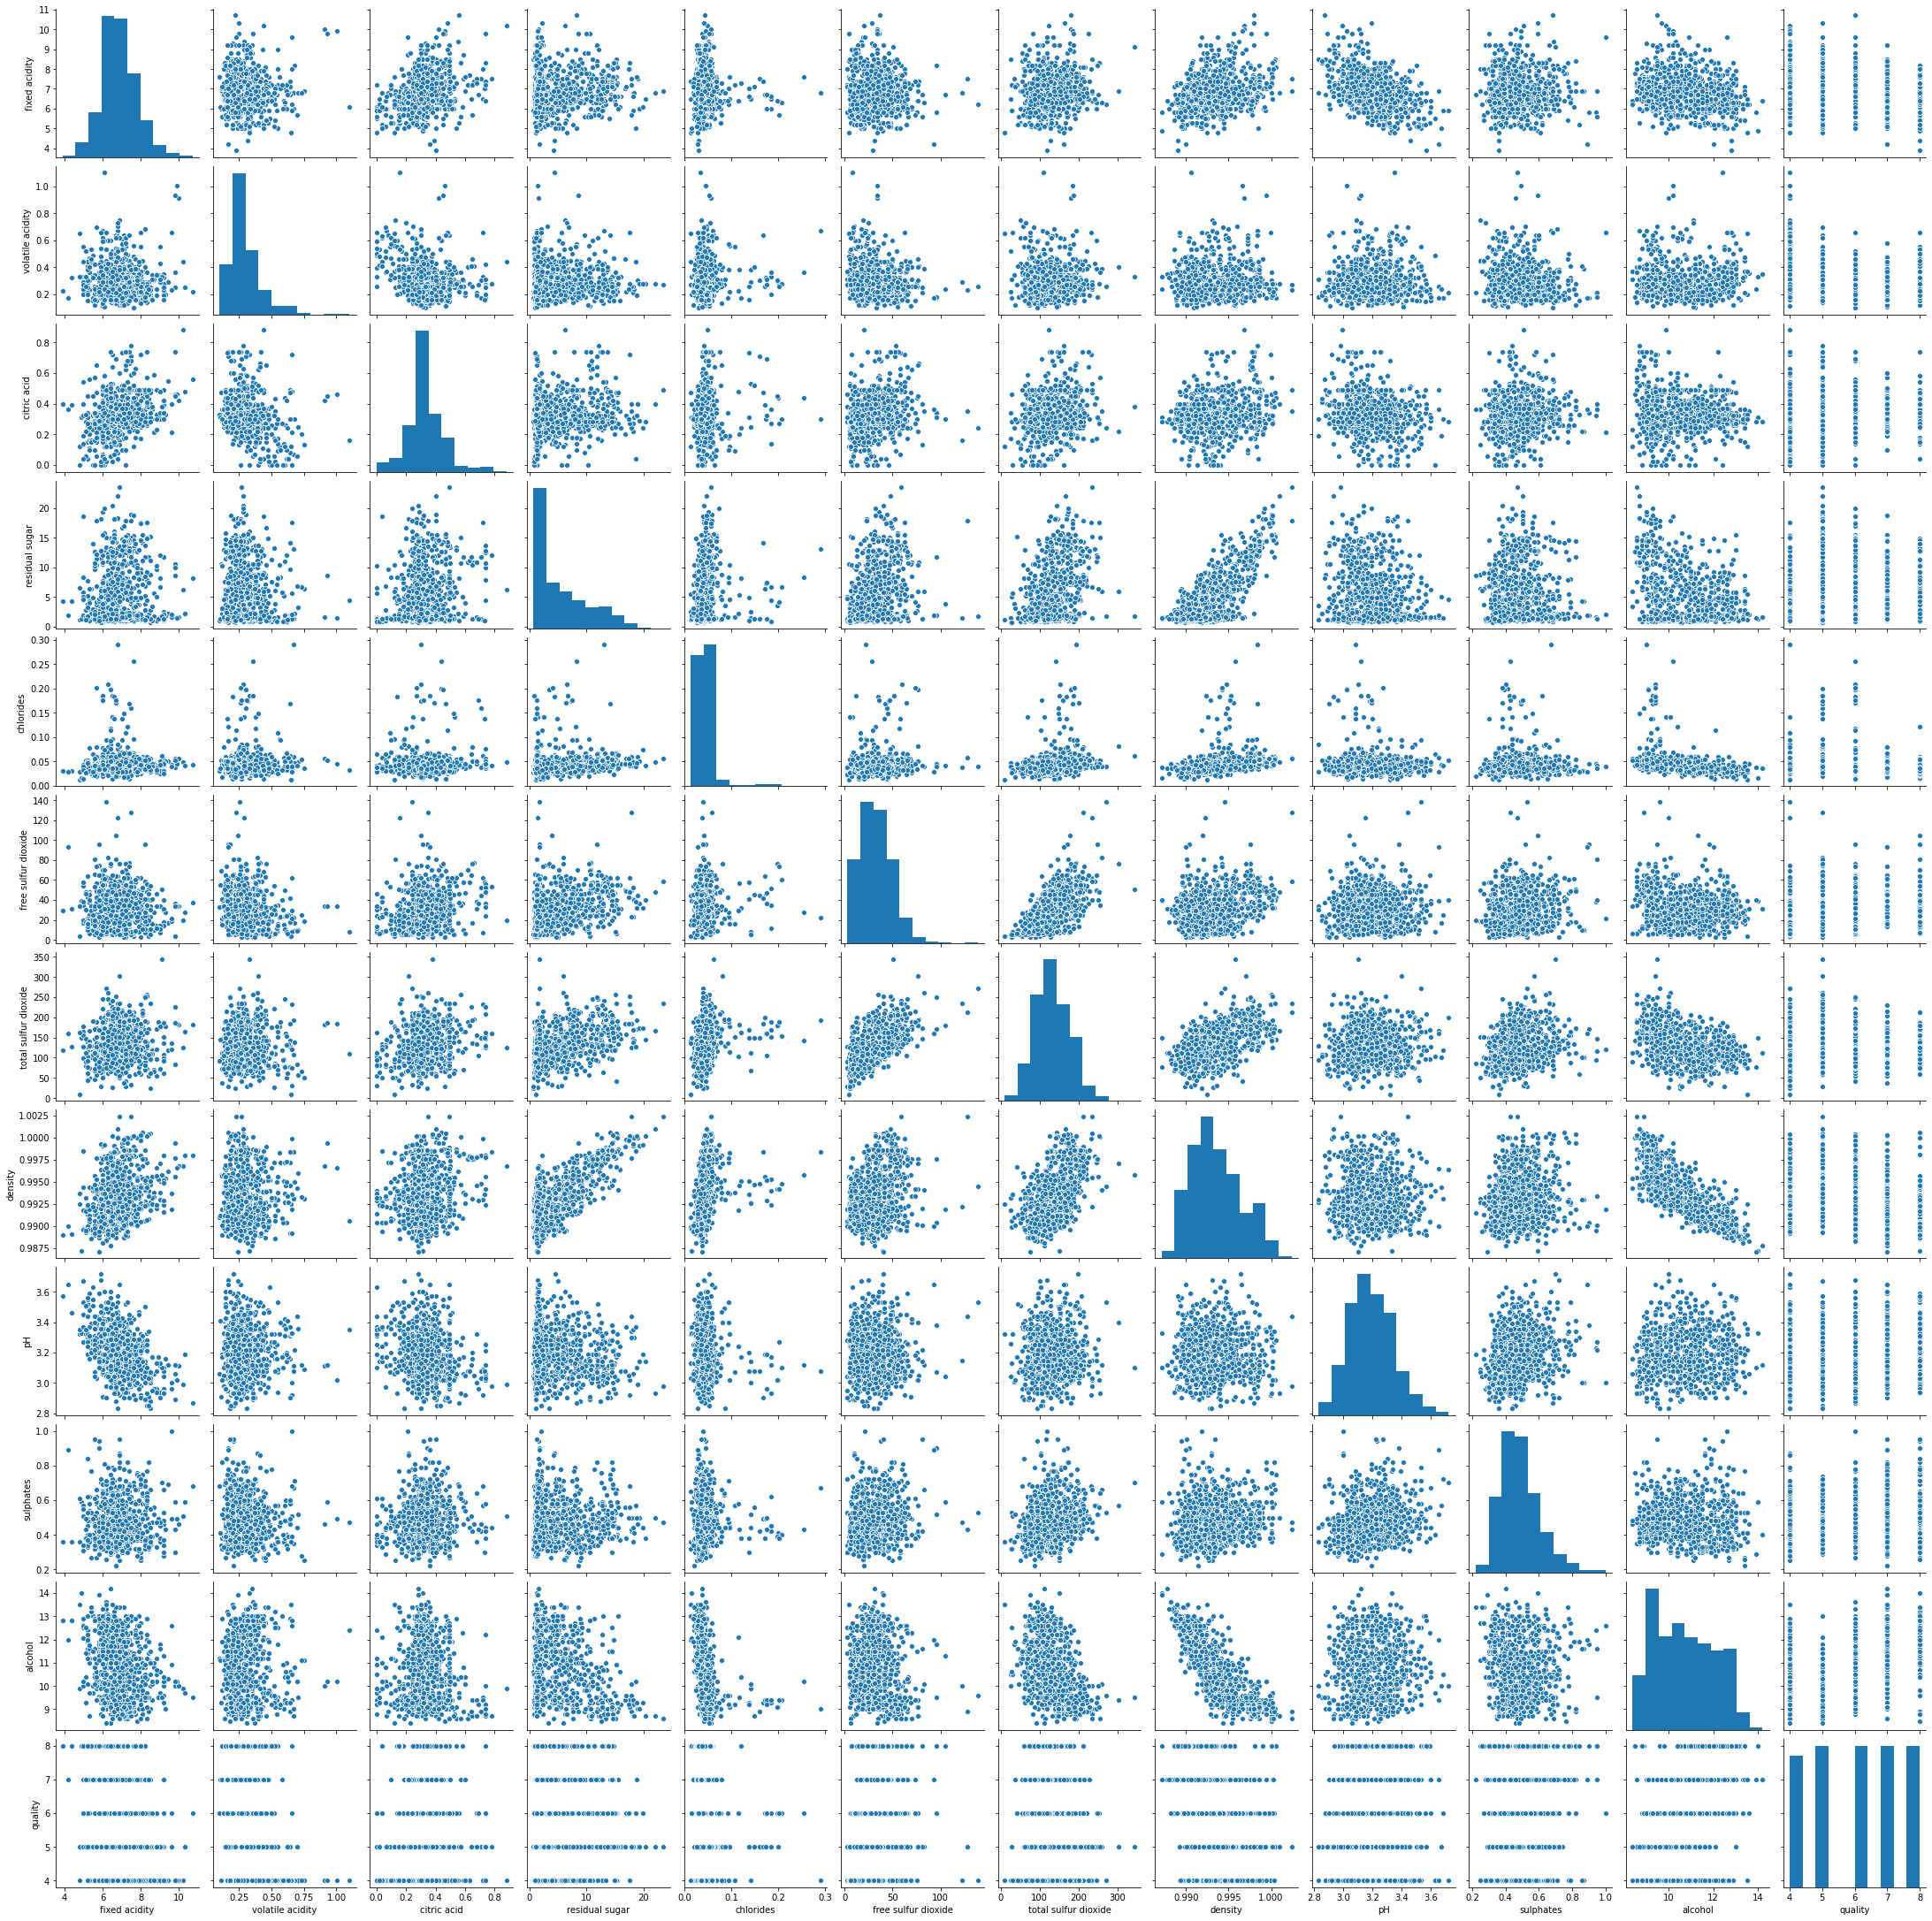

<IPython.core.display.Javascript object>

In [28]:
sns.pairplot(new_wines)
plt.show()

It looks like many of the distributions could benefit from a log transformation.  In particular: chlorides, residual sugar, and volatile acidity.

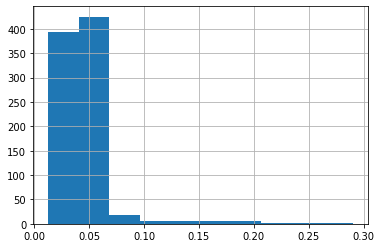

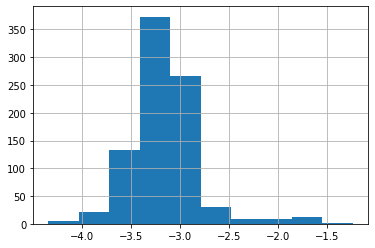

<IPython.core.display.Javascript object>

In [31]:
new_wines["chlorides"].hist()
plt.show()

new_wines["chlorides"] = np.log(new_wines["chlorides"])
new_wines["chlorides"].hist()
plt.show()

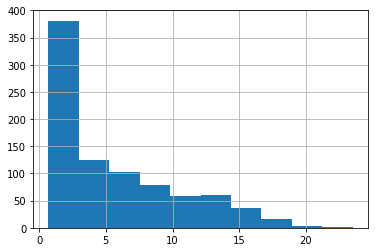

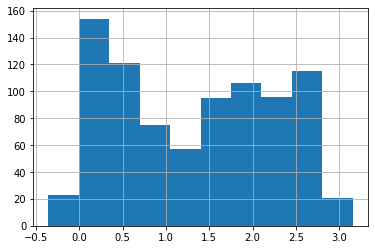

<IPython.core.display.Javascript object>

In [32]:
new_wines["residual sugar"].hist()
plt.show()

new_wines["residual sugar"] = np.log(new_wines["residual sugar"])
new_wines["residual sugar"].hist()
plt.show()

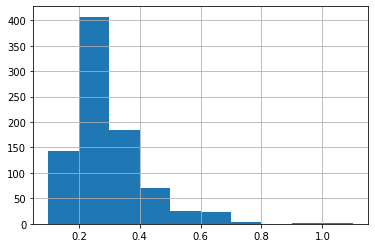

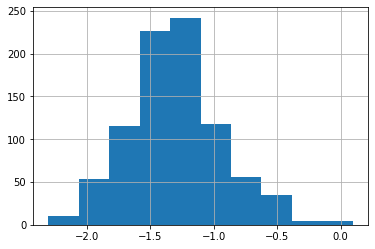

<IPython.core.display.Javascript object>

In [33]:
new_wines["volatile acidity"].hist()
plt.show()

new_wines["volatile acidity"] = np.log(new_wines["volatile acidity"])
new_wines["volatile acidity"].hist()
plt.show()

Let's also check for multicollinearity using a variance inflation factor function written by our instructor, Adam.

In [37]:
print_vif(new_wines.drop(columns=["quality"]))

VIF results
-------------------------------
const                   1.966462e+06
fixed acidity           2.566036e+00
volatile acidity        1.133966e+00
citric acid             1.242442e+00
residual sugar          5.765062e+00
chlorides               1.497815e+00
free sulfur dioxide     1.795844e+00
total sulfur dioxide    2.303261e+00
density                 1.717010e+01
pH                      1.855417e+00
sulphates               1.139825e+00
alcohol                 7.897204e+00
dtype: float64
-------------------------------



<IPython.core.display.Javascript object>

Let's drop `density`.

In [38]:
new_wines = new_wines.drop(columns=["density"])

print_vif(new_wines.drop(columns=["quality"]))

VIF results
-------------------------------
const                   1006.696413
fixed acidity              1.529060
volatile acidity           1.123617
citric acid                1.241983
residual sugar             1.288484
chlorides                  1.490471
free sulfur dioxide        1.784523
total sulfur dioxide       2.270165
pH                         1.416560
sulphates                  1.095319
alcohol                    1.752002
dtype: float64
-------------------------------



<IPython.core.display.Javascript object>

## Modeling

Perform a train/test split with 20% of the data in the test set.

In [75]:
X = new_wines.drop(columns=["quality"])
y = new_wines["quality"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

<IPython.core.display.Javascript object>

We're going to build... a modeling pipeline for KNN.

In [76]:
num_cols = np.array(X.columns)

<IPython.core.display.Javascript object>

In [77]:
# Preprocessing aka column transforming
preprocessing = ColumnTransformer(
    [
        # ('name_of_step', PreProcessingObject(), [list_of_cols])
        ("scale_nums", StandardScaler(), num_cols),
    ]
)

# Modeling pipeline (which will include the preprocessing pipeline)
pipeline = Pipeline(
    [
        ("preprocess", preprocessing),
        ("feat_select", SelectKBest(f_regression)),
        ("regress", KNeighborsRegressor()),
        #         ("regress", LinearRegression()),
    ]
)

grid = {
    "feat_select__k": range(1, X_train.shape[1] + 1),
    "regress__n_neighbors": range(15, 50),
    "regress__weights": ["uniform", "distance"],
    "regress__leaf_size": [25],
}

pipeline_cv = GridSearchCV(pipeline, grid, verbose=1, cv=3)
pipeline_cv.fit(X_train, y_train)

pipeline_cv.best_params_

Fitting 3 folds for each of 700 candidates, totalling 2100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2100 out of 2100 | elapsed:   17.0s finished


{'feat_select__k': 5,
 'regress__leaf_size': 25,
 'regress__n_neighbors': 23,
 'regress__weights': 'distance'}

<IPython.core.display.Javascript object>

In [78]:
train_score = pipeline_cv.score(X_train, y_train)
test_score = pipeline_cv.score(X_test, y_test)

print(f"train_score: {train_score}")
print(f"test_score: {test_score}")

train_score: 1.0
test_score: 0.6178644302447307


<IPython.core.display.Javascript object>

In [79]:
y_pred = pipeline_cv.predict(X_test)

errors = y_pred - y_test

abs_errors = errors.abs()

mae = abs_errors.mean()

mae

0.6436003262893094

<IPython.core.display.Javascript object>

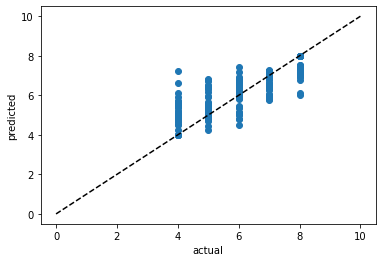

<IPython.core.display.Javascript object>

In [72]:
plt.scatter(y_test, y_pred)
plt.plot([0, 10], [0, 10], ls="--", c="black")
plt.xlabel("actual")
plt.ylabel("predicted")
plt.show()

# Compare to linear regression

In [52]:
# Preprocessing aka column transforming
preprocessing = ColumnTransformer(
    [
        # ('name_of_step', PreProcessingObject(), [list_of_cols])
        ("scale_nums", StandardScaler(), num_cols),
    ]
)

# Modeling pipeline (which will include the preprocessing pipeline)
pipeline = Pipeline(
    [
        ("preprocess", preprocessing),
        ("feat_select", SelectKBest(f_regression)),
        # ("regress", KNeighborsRegressor()),
        ("regress", LinearRegression()),
    ]
)

grid = {
    "feat_select__k": range(1, X_train.shape[1] + 1),
}

pipeline_cv = GridSearchCV(pipeline, grid, verbose=1, cv=5)
pipeline_cv.fit(X_train, y_train)

pipeline_cv.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.4s finished


{'feat_select__k': 10}

<IPython.core.display.Javascript object>

In [53]:
train_score = pipeline_cv.score(X_train, y_train)
test_score = pipeline_cv.score(X_test, y_test)

print(f"train_score: {train_score}")
print(f"test_score: {test_score}")

train_score: 0.4310906256255659
test_score: 0.45774246760035114


<IPython.core.display.Javascript object>

In [54]:
y_pred = pipeline_cv.predict(X_test)

errors = y_pred - y_test

abs_errors = errors.abs()

mae = abs_errors.mean()

mae

0.8435939400801579

<IPython.core.display.Javascript object>

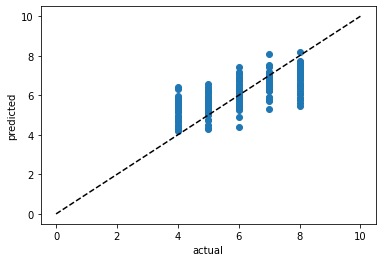

<IPython.core.display.Javascript object>

In [55]:
plt.scatter(y_test, y_pred)
plt.plot([0, 10], [0, 10], ls="--", c="black")
plt.xlabel("actual")
plt.ylabel("predicted")
plt.show()

Remembering what the prompt said:

Create a Jupyter notebook with your models. At the end in a markdown cell write a few paragraphs to describe the models' behaviors and why you favor one model or the other. Try to determine whether there is a situation where you would change your mind, or whether one is unambiguously better than the other. Lastly, try to note what it is about the data that causes the better model to outperform the weaker model. Submit a link to your notebook below.

My response:

The K-nearest neighbors is overfitting, but even so, does a better job predicting the data.  Both models are under-predicting the lower quality wines and over-predicting the higher quality wines.  

I would prefer the knn model if I just needed accuracy.  If I needed interpretability, I'd go with the OLS linear regression.